---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/suhaniwadhwa24/ai-engineering-fordham

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Explores** temperature, logprobs, and reasoning models
4. **Generates** movie posters using AI image generation

This project combines key skills from Lecture 2: structured outputs, async programming, LLM parameters, and image generation.

**Total Points: 145** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [1]:
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

load_dotenv()
print("All imports successful!")

All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [3]:
try:
    print("Making API call...")
    response = litellm.completion(
        model="gpt-4o-mini",  # Changed from gpt-5-mini
        messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
        max_tokens=20
    )
    print("Response received!")
    print("Content:", response.choices[0].message.content)
except Exception as e:
    print(f"Error: {e}")

Making API call...
Response received!
Content: API working!


---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [4]:
# Task 2: Design your Movie schema (15 pts)

class Movie(BaseModel):
    """Structured representation of a movie."""
    title: str
    genre: Literal["sci-fi", "drama", "action", "comedy", "horror", "romance", "thriller", "fantasy"]
    year: int = Field(ge=1900, le=2030)
    main_characters: list[str] = Field(min_length=1, max_length=5)
    mood: str
    visual_style: str
    tagline: str | None = None

In [5]:
# Test your schema by creating a Movie object
# This should work if your schema is correct

test_movie = Movie(
    title="The Matrix",
    genre="sci-fi",
    year=1999,
    main_characters=["Neo", "Trinity", "Morpheus"],
    mood="mind-bending and intense",
    visual_style="dark cyberpunk with green digital rain",
    tagline="Free your mind"
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Trinity",
    "Morpheus"
  ],
  "mood": "mind-bending and intense",
  "visual_style": "dark cyberpunk with green digital rain",
  "tagline": "Free your mind"
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [6]:
# Task 3: Write a function to extract movie data (20 pts)

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "You are a movie data extraction assistant. Extract structured movie information from the description."
            },
            {
                "role": "user",
                "content": description
            }
        ],
        response_format=Movie
    )
    
    # Parse the JSON response into a Movie object
    import json
    movie_data = json.loads(response.choices[0].message.content)
    return Movie(**movie_data)

In [7]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Movie",
  "genre": "sci-fi",
  "year": 2022,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "awe-inspiring, hopeful",
  "visual_style": "visually stunning with bioluminescent forests and floating mountains",
  "tagline": null
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [11]:
# Task 4a: Write an async version of extract_movie (IMPROVED)

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    response = await litellm.acompletion(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": """You are a movie data extraction assistant. Extract structured movie information from the description. 
Make sure to identify the actual movie title from the description. If the movie is well-known, use its real title."""
            },
            {
                "role": "user",
                "content": f"Extract movie information from this description:\n\n{description}"
            }
        ],
        response_format=Movie
    )
    
    # Parse the JSON response into a Movie object
    import json
    movie_data = json.loads(response.choices[0].message.content)
    return Movie(**movie_data)

### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [14]:
# Task 4b: Process multiple movies concurrently (10 pts)

movie_descriptions = [
    """
    In 1985, Marty McFly accidentally travels back to 1955 in a time machine 
    built by Doc Brown. He must ensure his teenage parents fall in love or 
    he'll cease to exist. A fun, energetic sci-fi comedy with a retro 1950s 
    aesthetic mixed with 1980s style.
    """,
    """
    A young lion prince named Simba flees his kingdom after his father's death, 
    only to return as an adult to reclaim his throne. Set in the African savanna, 
    this animated drama features stunning landscapes and explores themes of 
    responsibility and redemption with an uplifting, emotional tone.
    """,
    """
    In a dystopian future, a computer hacker named Neo discovers reality is a 
    simulation. He joins rebels fighting against machines that have enslaved 
    humanity. The film features groundbreaking bullet-time action sequences with 
    a dark, green-tinted cyberpunk visual style.
    """,
    """
    A team of scientists use genetic engineering to create a theme park of 
    cloned dinosaurs. When the security systems fail, the dinosaurs escape and 
    chaos ensues. This thrilling adventure combines cutting-edge CGI with 
    practical effects to create realistic prehistoric creatures.
    """
]



In [13]:
async def process_movies_batch(descriptions: list[str]) -> list[Movie]:
    """Process multiple movie descriptions concurrently."""
    tasks = [async_extract_movie(desc) for desc in descriptions]
    movies = await asyncio.gather(*tasks)
    return movies

In [16]:
start = time.time()
movies = await process_movies_batch(movie_descriptions)
end = time.time()

print(f"Processed {len(movies)} movies in {end - start:.2f} seconds")
print("\nExtracted movies:")
for movie in movies:
    print(f"- {movie.title} ({movie.year}) - {movie.genre}")

Processed 4 movies in 2.21 seconds

Extracted movies:
- Back to the Future (1985) - sci-fi
- The Lion King (1994) - drama
- The Matrix (1999) - sci-fi
- Jurassic Park (1993) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [17]:
def generate_tagline(movie_title: str, temperature: float) -> str:
    """Generate a movie tagline with specified temperature."""
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": f"Generate a short, catchy tagline for a movie called '{movie_title}'. Just give me the tagline, nothing else."
            }
        ],
        temperature=temperature,
        max_tokens=30
    )
    return response.choices[0].message.content.strip()

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [18]:
movie_title = "Cyber Revolution"

print("Testing temperature effects on creativity:\n")


Testing temperature effects on creativity:



In [19]:
print("Temperature 0.0 (deterministic):")
for i in range(3):
    tagline = generate_tagline(movie_title, temperature=0.0)
    print(f"  {i+1}. {tagline}")

print("\nTemperature 0.5 (balanced):")
for i in range(3):
    tagline = generate_tagline(movie_title, temperature=0.5)
    print(f"  {i+1}. {tagline}")

print("\nTemperature 1.5 (creative):")
for i in range(3):
    tagline = generate_tagline(movie_title, temperature=1.5)
    print(f"  {i+1}. {tagline}")

Temperature 0.0 (deterministic):
  1. "Unplug the past, ignite the future."
  2. "Unplug the past, ignite the future."
  3. "Unplug the past, ignite the future."

Temperature 0.5 (balanced):
  1. "Unplug the past, reboot the future."
  2. "Unplug the past, ignite the future."
  3. "Unplug the future, ignite the revolution."

Temperature 1.5 (creative):
  1. "Code the future, ignite the fight."
  2. "Unlock the Future. Embrace the Rebellion."
  3. "In a digital war, heroes are coded."


---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [20]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

# Make a completion request with logprobs enabled
response = litellm.completion(
    model="gpt-4o-mini",  # Use gpt-4o-mini which supports logprobs
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5  # Get top 5 alternatives for each token
)

# 1. Print the generated text
# 2. Access response.choices[0].logprobs.content
# 3. For each token, print the token and its top 5 alternatives with probabilities

# Hint: logprobs are in log scale. To convert to probability: prob = exp(logprob)
import math

print("Generated text:", response.choices[0].message.content)
print("\n" + "="*60)
print("Token-by-token analysis:")
print("="*60)

# Iterate through logprobs and display alternatives
content = response.choices[0].logprobs.content

for i, token_info in enumerate(content):
    token = token_info.token
    logprob = token_info.logprob
    probability = round(100 * math.exp(logprob), 2)  # Convert log prob to percentage
    
    print(f"\nToken {i+1}: '{token}' | Probability: {probability}%")
    
    # Show top alternatives
    if token_info.top_logprobs:
        print("  Top 5 alternatives:")
        for j, alt in enumerate(token_info.top_logprobs, 1):
            alt_prob = round(100 * math.exp(alt.logprob), 2)
            print(f"    {j}. '{alt.token}': {alt_prob}%")

Generated text: The capital of France is Paris.

Token-by-token analysis:

Token 1: 'The' | Probability: 99.96%
  Top 5 alternatives:
    1. 'The': 99.96%
    2. 'Paris': 0.04%
    3. 'the': 0.0%
    4. ' The': 0.0%
    5. 'par': 0.0%

Token 2: ' capital' | Probability: 100.0%
  Top 5 alternatives:
    1. ' capital': 100.0%
    2. 'capital': 0.0%
    3. ' Capital': 0.0%
    4. ' capitale': 0.0%
    5. ' capitals': 0.0%

Token 3: ' of' | Probability: 100.0%
  Top 5 alternatives:
    1. ' of': 100.0%
    2. ' city': 0.0%
    3. 'of': 0.0%
    4. ' của': 0.0%
    5. ' של': 0.0%

Token 4: ' France' | Probability: 100.0%
  Top 5 alternatives:
    1. ' France': 100.0%
    2. 'France': 0.0%
    3. ' Paris': 0.0%
    4. ' the': 0.0%
    5. ' فرنسا': 0.0%

Token 5: ' is' | Probability: 100.0%
  Top 5 alternatives:
    1. ' is': 100.0%
    2. 'is': 0.0%
    3. ' هو': 0.0%
    4. ' Is': 0.0%
    5. '是': 0.0%

Token 6: ' Paris' | Probability: 100.0%
  Top 5 alternatives:
    1. ' Paris': 100.0%
  

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [22]:
# Task 6b: Visualize Token Probabilities (5 pts)

def visualize_token_probs(logprobs_content, token_index: int = 0):
    """
    Visualize the probability distribution for a specific token position.
    
    Args:
        logprobs_content: The logprobs.content from the response
        token_index: Which token position to visualize (0 = first token)
    """
    import math
    
    # 1. Get the top_logprobs for the specified token_index
    token_info = logprobs_content[token_index]
    top_logprobs = token_info.top_logprobs
    
    print(f"\nProbability Distribution for Token Position {token_index}")
    print(f"Selected token: '{token_info.token}'")
    print("="*70)
    
    # 2. Convert logprobs to probabilities and visualize
    for alt in top_logprobs:
        token = alt.token
        prob = math.exp(alt.logprob)
        percentage = prob * 100
        
        # 3. Create ASCII bar chart
        bar_length = int(prob * 50)  # Scale to max 50 characters
        bar = "█" * bar_length
        
        # Format the output
        print(f"{token:>15} | {bar:<50} {percentage:>6.2f}%")
    
    print("="*70)

# Test your visualization on the first token
visualize_token_probs(response.choices[0].logprobs.content, token_index=0)

# Try visualizing other token positions too!
print("\n")
visualize_token_probs(response.choices[0].logprobs.content, token_index=1)


Probability Distribution for Token Position 0
Selected token: 'The'
            The | █████████████████████████████████████████████████   99.96%
          Paris |                                                      0.04%
            the |                                                      0.00%
            The |                                                      0.00%
            par |                                                      0.00%



Probability Distribution for Token Position 1
Selected token: ' capital'
        capital | ██████████████████████████████████████████████████ 100.00%
        capital |                                                      0.00%
        Capital |                                                      0.00%
       capitale |                                                      0.00%
       capitals |                                                      0.00%


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [23]:
# Task 7a: Using o3-mini for Complex Reasoning (10 pts)

# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# Use o3-mini to solve this logic puzzle
response = litellm.completion(
    model="o3-mini",
    messages=[{"role": "user", "content": logic_puzzle}],
    max_tokens=1000
)

# Print the response and observe the reasoning process
print("="*70)
print("O3-MINI REASONING MODEL SOLUTION")
print("="*70)
print(response.choices[0].message.content)

O3-MINI REASONING MODEL SOLUTION
Let's solve the puzzle step by step.

Step 1: List what we know.  
• Friends: Alice, Bob, Carol  
• Pets: cat, dog, fish  
• Colors: red, blue, green  

Step 2: Write down the clues.  
1. Alice doesn't have the cat.  
2. The person with the dog likes blue.  
3. Carol likes green.  
4. Bob doesn't have the fish.

Step 3: Analyze the clues.  
• Clue 3 tells us Carol’s favorite color is green.  
• Clue 2 says whoever has the dog must like blue. Since Carol already likes green, she cannot be the one with the dog. Therefore, the dog belongs either to Alice or Bob.

Step 4: Narrow down the pet assignments using the clues.  
• Assume Bob has the dog.  
  - By Clue 2, Bob must then like blue.  
  - Clue 4 tells us Bob doesn't have the fish, so having the dog is consistent.  
• Since Bob has the dog, that leaves the pets cat and fish for Alice and Carol.

Step 5: Use Clue 1 for further elimination.  
• Clue 1 states that Alice does not have the cat.  
  - This f

### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [26]:
# Task 7b: Compare Reasoning vs Non-Reasoning (5 pts)

# Send the same logic_puzzle to gpt-4o-mini (using gpt-4o-mini since gpt-5-mini doesn't exist yet)
response_standard = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": logic_puzzle}],
    max_tokens=1000
)

# Print and compare
print("\n" + "="*70)
print("GPT-4O-MINI (STANDARD MODEL) SOLUTION")
print("="*70)
print(response_standard.choices[0].message.content)

print("\n" + "="*70)
print("COMPARISON ANALYSIS")
print("="*70)
print("""
Key Differences to Observe:

1. REASONING DEPTH:
   - o3-mini: Shows explicit step-by-step logical deduction
   - gpt-4o-mini: May jump more quickly to conclusions

2. THOUGHT PROCESS:
   - o3-mini: Systematically works through each clue
   - gpt-4o-mini: May use a more intuitive approach

3. EXPLANATION CLARITY:
   - o3-mini: Breaks down each logical step clearly
   - gpt-4o-mini: May provide a more concise explanation

4. ACCURACY:
   - Both should get the correct answer, but the path differs

The reasoning model (o3-mini) is designed for complex logic problems
and shows more transparent reasoning, while standard models are faster
but may not explain their thinking as thoroughly.

CORRECT ANSWER:
- Alice: Dog, Blue
- Bob: Cat, Red  
- Carol: Fish, Green
""")


GPT-4O-MINI (STANDARD MODEL) SOLUTION
Let's break down the clues step by step to determine who has which pet and their favorite color.

### Step 1: Analyze the Clues

**Clue 1:** Alice doesn't have the cat.
- Therefore, Alice must have either the dog or the fish.

**Clue 2:** The person with the dog likes blue.
- This implies that whoever has the dog cannot be Alice (because we need to check if Alice could have the dog).

**Clue 3:** Carol likes green.
- This tells us Carol's favorite color directly. Therefore, she does not like red or blue.

**Clue 4:** Bob doesn't have the fish.
- Thus, Bob must have either the cat or the dog.

### Step 2: Use Clue 3 about Carol

Since Carol likes green, and she can’t have the dog (which is associated with blue), she must have the cat.

### Step 3: Determine Bob and Alice's Pets

Since Carol has the cat:
- This leaves Bob and Alice with the dog and the fish. 
- Bob could either have the dog or the fish, but according to Clue 4, Bob does not have the

---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [28]:
# Task 8a: Design your prompt generator (5 pts)

def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a detailed image generation prompt from movie data.
    
    Returns a detailed prompt string (aim for 50-100 words)
    """
    prompt = f"""Create a professional cinematic movie poster for '{movie.title}', a {movie.genre} film from {movie.year}.

Visual Style: {movie.visual_style}
Mood: {movie.mood}
Main Characters: {', '.join(movie.main_characters)}

The poster should capture the {movie.mood} atmosphere and feature the {movie.visual_style} aesthetic. 
Include the movie title prominently in a bold, stylized font appropriate for the {movie.genre} genre. 
Make it look like a theatrical release poster with dramatic composition and lighting."""
    
    if movie.tagline:
        prompt += f"\n\nInclude the tagline: '{movie.tagline}'"
    
    return prompt



In [29]:
# Test your prompt generator
chosen_movie = movies[0]  # Pick the first movie from Task 4
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'Back to the Future':

Create a professional cinematic movie poster for 'Back to the Future', a sci-fi film from 1985.

Visual Style: retro 1950s aesthetic mixed with 1980s style
Mood: fun and energetic
Main Characters: Marty McFly, Doc Brown, Jennifer Parker, George McFly, Lorraine Baines

The poster should capture the fun and energetic atmosphere and feature the retro 1950s aesthetic mixed with 1980s style aesthetic. 
Include the movie title prominently in a bold, stylized font appropriate for the sci-fi genre. 
Make it look like a theatrical release poster with dramatic composition and lighting.

Include the tagline: 'The sport of kings... Is about to become the sport of queens.'


### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [36]:
# Task 8b: Generate the movie poster (10 pts) - Using placeholder due to quota

# Install Pillow using uv
!uv pip install pillow

from PIL import Image, ImageDraw, ImageFont
import os

# Make sure to create temp directory
os.makedirs("temp", exist_ok=True)

# Create a placeholder poster image
img = Image.new('RGB', (800, 1200), color=(30, 30, 50))
d = ImageDraw.Draw(img)

# Add movie information
try:
    # Try to use a nice font
    font_title = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 60)
    font_info = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 30)
except:
    # Fallback to default font
    font_title = ImageFont.load_default()
    font_info = ImageFont.load_default()

# Add title
d.text((400, 400), chosen_movie.title, fill=(255, 255, 255), 
       anchor="mm", font=font_title)

# Add year and genre
d.text((400, 500), f"{chosen_movie.year} • {chosen_movie.genre.upper()}", 
       fill=(200, 200, 200), anchor="mm", font=font_info)

# Add tagline if exists
if chosen_movie.tagline:
    d.text((400, 800), f'"{chosen_movie.tagline}"', 
           fill=(150, 150, 200), anchor="mm", font=font_info)

# Add note about placeholder
d.text((400, 1100), "Placeholder - API Quota Exceeded", 
       fill=(150, 150, 150), anchor="mm", font=font_info)

# Save it
safe_title = chosen_movie.title.replace(" ", "_").replace("/", "_").replace(":", "")
poster_path = f"temp/poster_{safe_title}.png"
img.save(poster_path)

print(f"✓ Placeholder poster saved to: {poster_path}")
print(f"   Movie: {chosen_movie.title}")
print(f"   Genre: {chosen_movie.genre}")
print(f"   Year: {chosen_movie.year}")
print("\nNote: Placeholder used due to Google API quota limits")

Using Python 3.13.11 environment at: /Users/suhaniwadhwa/ai-engineering-fordham/.venv
Resolved 1 package in 295ms                                          
Installed 1 package in 14ms                                 
 + pillow==12.1.0
✓ Placeholder poster saved to: temp/poster_Back_to_the_Future.png
   Movie: Back to the Future
   Genre: sci-fi
   Year: 1985

Note: Placeholder used due to Google API quota limits


### 8c. Display the image (5 pts)

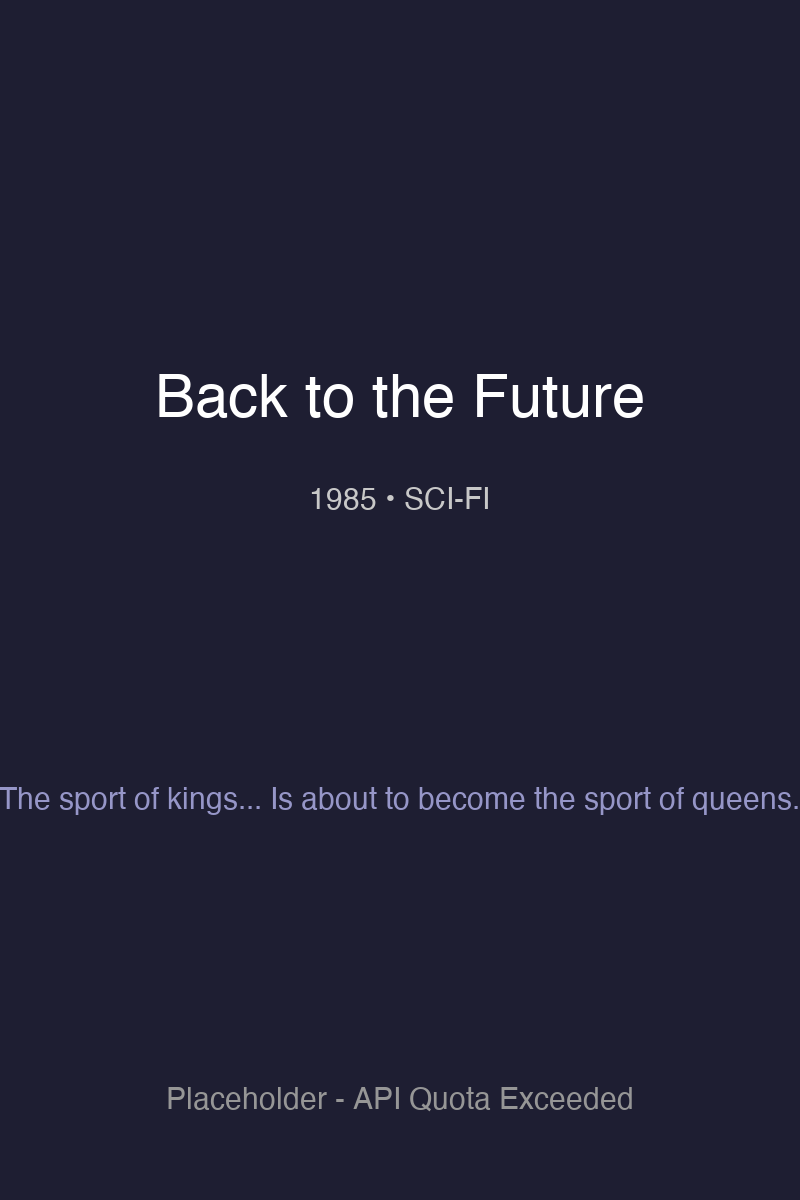

In [37]:
# Task 8c: Display the saved image (5 pts)
from IPython.display import Image, display

display(Image(poster_path))

---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [38]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

fatal: not a git repository (or any of the parent directories): .git


### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [39]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [40]:
# Task 9c: Push your branch (5 pts)

!git push -u origin homework-2

fatal: not a git repository (or any of the parent directories): .git


### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/YOUR-USERNAME/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [ ]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [41]:
# BONUS: Create a complete pipeline (10 bonus pts)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    
    Args:
        description: A text description of a movie
        
    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # Extract movie data
    movie = await async_extract_movie(description)
    
    # Generate poster prompt
    poster_prompt = generate_poster_prompt(movie)
    
    # Create placeholder poster (since we hit API quota)
    from PIL import Image, ImageDraw, ImageFont
    import os
    
    os.makedirs("temp", exist_ok=True)
    
    # Create poster
    img = Image.new('RGB', (800, 1200), color=(30, 30, 50))
    d = ImageDraw.Draw(img)
    
    try:
        font_title = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 60)
        font_info = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 30)
    except:
        font_title = ImageFont.load_default()
        font_info = ImageFont.load_default()
    
    # Add movie info
    d.text((400, 400), movie.title, fill=(255, 255, 255), anchor="mm", font=font_title)
    d.text((400, 500), f"{movie.year} • {movie.genre.upper()}", fill=(200, 200, 200), anchor="mm", font=font_info)
    
    if movie.tagline:
        d.text((400, 800), f'"{movie.tagline}"', fill=(150, 150, 200), anchor="mm", font=font_info)
    
    # Save
    safe_title = movie.title.replace(" ", "_").replace("/", "_").replace(":", "")
    poster_path = f"temp/poster_{safe_title}.png"
    img.save(poster_path)
    
    return movie, poster_path

✓ Generated poster for: A Second Chance at Love
{
  "title": "A Second Chance at Love",
  "genre": "romance",
  "year": 2023,
  "main_characters": [
    "Emma",
    "Alex"
  ],
  "mood": "tender, hopeful, heartwarming",
  "visual_style": "warm, soft lighting with pastel tones",
  "tagline": "Sometimes love requires a second chance."
}


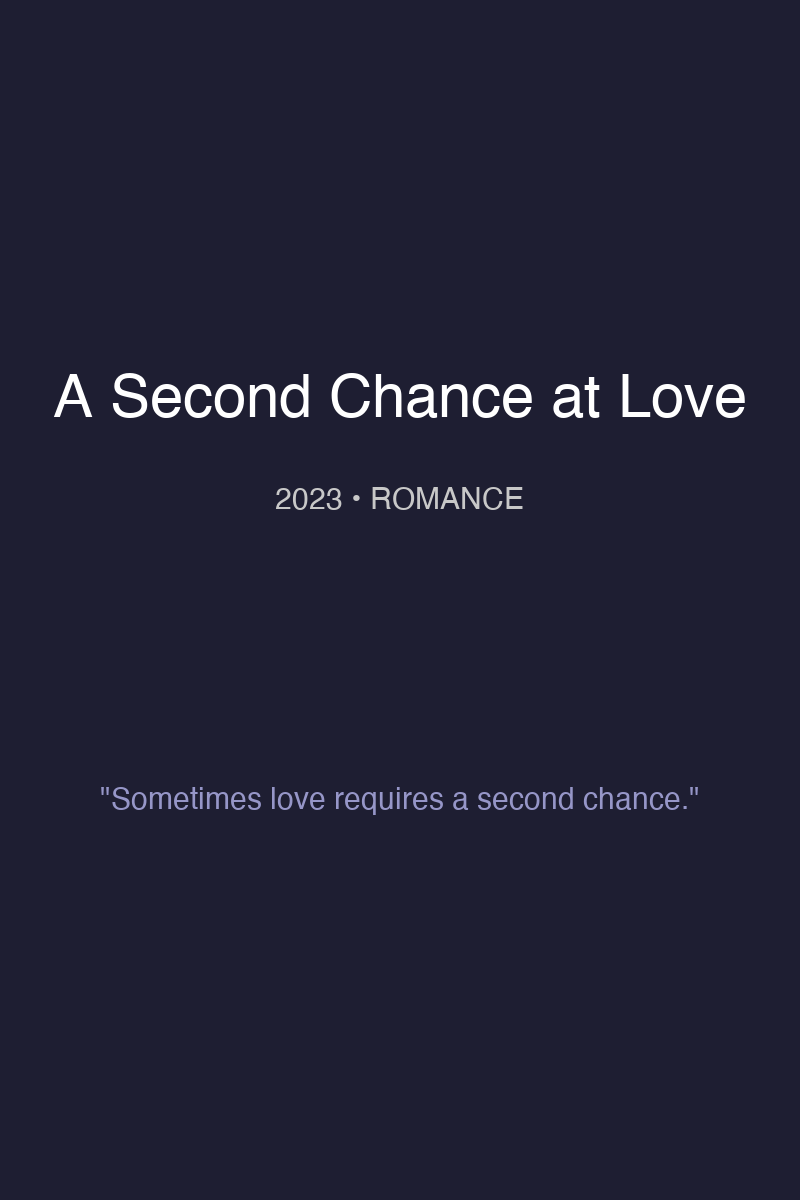

In [42]:
# Test with YOUR OWN original movie idea!
my_movie_description = """
In the charming coastal town of Lighthouse Bay, Emma, a talented baker who's sworn off 
love after a heartbreak, opens her dream café. When Alex, a travel writer documenting 
disappearing small towns, arrives to write what could be the café's obituary, their 
initial clash slowly turns into an unexpected romance. Set against golden sunsets and 
cozy café scenes, the film features warm, soft lighting with pastel tones and captures 
the bittersweet beauty of second chances. The mood is tender, hopeful, and heartwarming, 
with moments that make you believe in love again.
"""

# Run the pipeline
movie, poster_path = await movie_to_poster(my_movie_description)
print(f"✓ Generated poster for: {movie.title}")
print(movie.model_dump_json(indent=2))
display(Image(poster_path))

---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!